# Options Pricing with Binomial Model

The objective is to try to value index options (european) and stock options (american) on the Swedish stock exchange Nasaq OMXS. The binomial model is relativley simple, however, care has to be taken when dealing with dividend paying underlyings. In this notebook, only the stock on SAAB B has a dividend. The index option on OMXS30 has no dividend yield during the pricing period, due to Swedish stocks primarly paying dividends in Q1. 

The methodology of building a recombinding tree can be made extremely efficiently with the right data structures. This is not done here.

As with Black-Sholes a model for the underlying has to be specified. In this case the underlying follows a (discrete) stochastic process called CRR (Cox Ross Rubenstein) in which
$$
S_t = S_0 \prod_{i=1}^t \xi_i \quad \xi_i \overset{\text{iid}}{\sim}\text{Be}(q) \quad \forall i \in \{1,\ldots, t\}.
$$
In this model, the random variable $\xi_i$ can take on values
$$
\xi_i=\left\{
\begin{array}{ll}
u &\text{with probability } p, \\ 
d &\text{with probability } q.
\end{array} 
\right.
$$
In this way the stock can move up or down with the multiplicative factor of $u$ and $d$ respectively. In the CRR model, the $u$ and $d$ are parameterized as $u = \exp{\sigma\sqrt{\Delta t}}$ and $d=1/u$.

The risk neutral probability can be computed as 
$$
    q = \frac{e^{r \Delta t - d}}{u-d},
$$
for underlyings without dividend yields and 
$$
q = \frac{e^{(r-q)\Delta t - d}}{u-d},
$$
for underlyings with dividend yields.

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'retina'
sns.set_theme()
sns.set_style("whitegrid", {'grid.linestyle': '--'})
seq_col_brew = sns.color_palette("flag_r", 4)
sns.set_palette(seq_col_brew)

### Valuing Index Call Options

Some data for the OMXS30 index call options provided by Reuters.

* Options Price (bid/ask): 55.50/59.50
* Option Vol (bid/ask):    22.85/24.61
* OMXS30 Points (close): 1965.29 
* OIS discount factor: 0.9984 (1M) 24 days
* Futures Price: 1964.50 @ 18 NOV
* Time To Maturity (years): 24/365
* Time Step: 1/365

In [412]:
rate = -1/(1/12) * np.log(0.9984)
print(f"Risk Free Rate: {rate*100} %")
div_yield = rate - 1/(24/365) * np.log(1964.50/1965.29)

Risk Free Rate: 1.9215376403686548 %


In [413]:
from scipy.stats import norm

def black76(imp_vol, forward, strike, expiry, rate, type="C"):
    d1 = 1/(imp_vol * np.sqrt(expiry)) * (np.log(forward/strike) + imp_vol**2/2 * expiry)
    d2 = d1 - imp_vol * np.sqrt(expiry)
    discount = np.exp(-rate * expiry)
    return discount * (forward * norm.cdf(d1) - strike * norm.cdf(d2)) 

def black_sholes(imp_vol, spot, strike, expiry, rate, type="C"):
    d1 = 1/(imp_vol * np.sqrt(expiry)) * (np.log(spot/strike) + (rate + imp_vol**2/2) * expiry)
    d2 = d1 - imp_vol * np.sqrt(expiry)
    discount = np.exp(-rate * expiry)
    return spot * norm.cdf(d1) - strike * norm.cdf(d2) * discount 

We are valuing the bid price, hence 55.50 IV calculation. We can note, that the IV from the option is about 1 % higher than the quoted bid IV from Reuters, suggesting something is slightly off. 

In [427]:
# Extracting the implied volatility.
from scipy.optimize import root_scalar

def formatted_function(imp_vol):
    return black_sholes(imp_vol, 1965.29, 1950, 24/365, rate, "C") - 55.50
print(root_scalar(formatted_function, bracket=[0, 0.25]))
print(black_sholes(0.23027960372852604, 1965.29, 1950, 24/365, rate, "C"))

      converged: True
           flag: 'converged'
 function_calls: 7
     iterations: 6
           root: 0.23027960372852446
55.500000000000455


/var/folders/d7/rpl_88f12ln2z1s2h4m9ybjm0000gn/T/ipykernel_6691/2261038978.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = 1/(imp_vol * np.sqrt(expiry)) * (np.log(spot/strike) + (rate + imp_vol**2/2) * expiry)


We construct the binomial tree is made in a upper triangular matrix as

$$
    \begin{bmatrix} 
    S_0 & \dots  & S_0u^n\\
    \vdots & \ddots & \vdots\\
    0 & \dots  & S_0d^n 
    \end{bmatrix},
$$

where any element in the matrix is $[S]_{ij} = S_0u^{j}d^{i-j}$ and the # of steps is simply $n = \lfloor{\frac{T}{\Delta t}}\rfloor{}$. 

The payoff function of the call option is simply $\text{max}\{S_T-K ,0 \}$. This is applied on the last column of the spot matrix.

In [415]:
def call_payoff(spot, strike):
    for i in range(len(spot)):
        spot[i] = np.max([spot[i]-strike,0])    
    return spot

In [416]:
def euro_call(next, q):
    number_of_prices = len(next)
    current = np.zeros(number_of_prices-1)
    for i in range(len(current)):
        current[i] = q * next[i] + (1-q) * next[i+1]
    return current

In [417]:
def american_call(next, q, spot):
    number_of_prices = len(next)
    current = np.zeros(number_of_prices-1)
    for i in range(len(current)):
        current[i] = np.max([q * next[i] + (1-q) * next[i+1], spot[i]])
    return current

The option's price is the calculated recursively backwards. It suffices to keep the precious array of options prices, making this computation highly efficient.

For european call options we have:

$$
C_{ij} = q C_{i j} + (1-q) C_{i j-1}.
$$

For american call options we have:
$$
C_{ij} = \text{max} \{S_ij-K, q C_{i j} + (1-q) C_{i j-1} \}
$$

In [473]:
def price_option(imp_vol, spot, strike, expiry, delta_t, rate, div_yield, type="CE"):
    """
    type: Call European (CE) or Call American (CA).
    """

    # Initialize parameters.
    u = np.exp(imp_vol*np.sqrt(delta_t))
    d = 1/u
    q = (np.exp((rate-div_yield) * delta_t) - d) / (u - d)
    steps = int(np.floor(expiry/delta_t))
    
    # Build spot matrix.
    spot_matrix = np.zeros((steps+1, steps+1))
    for i in range(steps+1):
        for j in range(i, steps+1):
            if j >= i:
                spot_matrix[i,j] = spot * u **(j-i) * d**(i)
    

    # Pricing EURPOEAN CALL OPTIONS HERE:
    if type == "CE":
        next = call_payoff(spot_matrix[:,-1], strike)
        for i in range(steps):
            current = euro_call(next, q)
            next = current

    # Pricing AMERICAN CALL OPTIONS HERE:
    if type == "AC":
        next = call_payoff(spot_matrix[:,-1], strike)
        for i in range(steps):
            current = american_call(next, q, spot_matrix[:,-i-1]-strike)
            next = current

    options_price = next[0]
    return options_price

In [474]:
prices = []
steps = []
reuters_iv = 0.2285
for i in range(5,195):
    prices.append(price_option(reuters_iv, 1965.90, 1950, 24/365, 24/365/(i), rate, 0))
    steps.append(i)

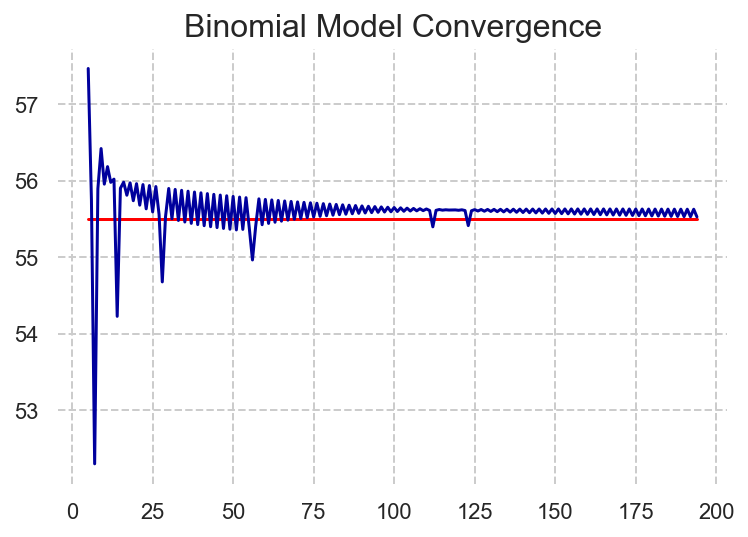

In [475]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
ax.plot(steps, len(steps)*[55.50], color='red')
ax.plot(steps, prices)
ax.set_title("Binomial Model Convergence", fontsize=16)
plt.box(False)
plt.show()

In [456]:
# Extracting the implied volatility.
def formatted_function(imp_vol):
    return black_sholes(imp_vol, 1974.277, 2000, 47/365, rate, "C") - 57.25
print(root_scalar(formatted_function, bracket=[0, 1]))
print(black_sholes(0.23634366435523096, 1974.277, 2000, 47/365, rate, "C"))

      converged: True
           flag: 'converged'
 function_calls: 7
     iterations: 6
           root: 0.23634366435523096
57.25


/var/folders/d7/rpl_88f12ln2z1s2h4m9ybjm0000gn/T/ipykernel_6691/2261038978.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = 1/(imp_vol * np.sqrt(expiry)) * (np.log(spot/strike) + (rate + imp_vol**2/2) * expiry)


In [457]:
prices = []
steps = []

for i in range(5,250):
    prices.append(price_option(0.23634366435523096, 1974.277, 2000, 47/365, 47/365/i, rate, 0, type="CE"))
    steps.append(i)

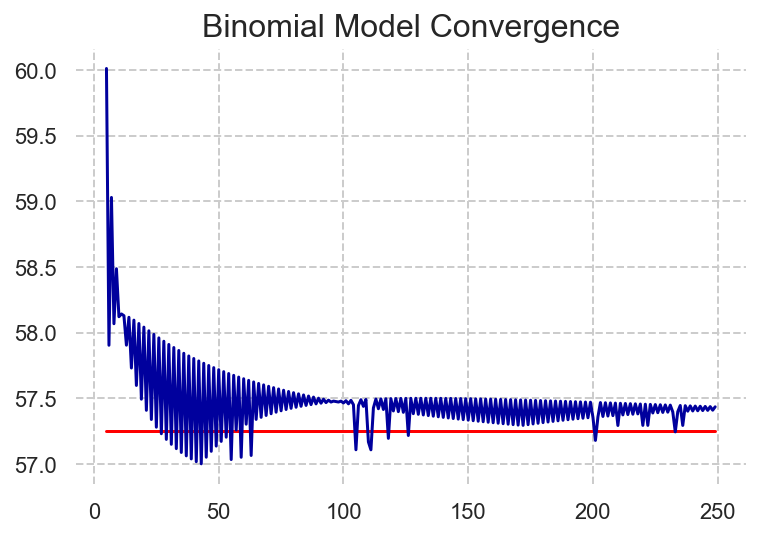

In [458]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
ax.plot(steps, len(steps)*[57.25], color='red')
ax.plot(steps, prices)
ax.set_title("Binomial Model Convergence", fontsize=16)
plt.box(False)
plt.show()

In [468]:
black_sholes(0.2, 100, 95, 1, 0.01, 0)

11.060209946964036

In [492]:
price_option(0.2, 100, 95, 1, 1/250, 0.01, 0)

11.165377189951688

In [493]:
prices = []
steps = []
for i in range(5,250):
    prices.append(price_option(0.20, 100, 95, 1, 365/365/i, 0.01, 0, type="CE"))
    steps.append(i)

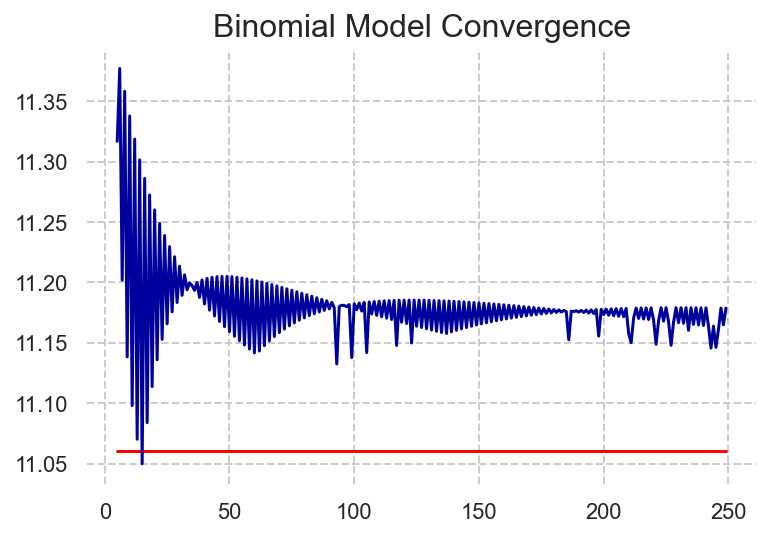

In [495]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
ax.plot(steps, len(steps)*[11.060209946964036], color='red')
ax.plot(steps, prices)
ax.set_title("Binomial Model Convergence", fontsize=16)
plt.box(False)
plt.show()